In [1]:
%load_ext autoreload
%autoreload 2

## INTRO & SETTINGS

The goal of this tutorial is to show the capabilities of `lf2i` and `Waldo` with a simple example: inferring the mean $\theta \in \mathbb{R}^{2}$ of a Gaussian model with fixed covariance, and a Gaussian prior distribution

$$\boldsymbol{\theta} \sim \mathcal{N}(\mathbb{0}, 0.1 \cdot \mathbb{I}), \\ \text{ } \mathbf{X}|\boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{\theta}, 0.01 \cdot \mathbb{I})$$

In addition, we assume that we only observe one sample for each true $\boldsymbol{\theta}$, i.e., $n=1$. \
For this tutorial, we leverage a posterior estimator (`NPE`) as the main underlying inferential model.

In [2]:
# SETTINGS

LIKELIHOOD_COV = 0.01
PRIOR_LOC = 0
PRIOR_COV = 0.1

PARAM_DIM = 2
DATA_DIM = 2
BATCH_SIZE = 1  # assume we get to see only one observed sample for each “true” parameter
PARAM_SPACE_BOUNDS = {'low': -1.5, 'high': 1.5}  # a grid of points over [low, high]^(param_dim) is used to construct confidence sets

CONFIDENCE_LEVEL = 0.90

## SIMULATE

Let's start from the simulator, which is used internally to generate the data needed to 
1. estimate the test statistics;
2. estimate the critical values; and 
3. diagnose the constructed confidence regions 

In [3]:
from lf2i.simulator.gaussian import GaussianMean

In [4]:
simulator = GaussianMean(
    likelihood_cov=LIKELIHOOD_COV,
    prior='gaussian',
    poi_space_bounds=PARAM_SPACE_BOUNDS,
    poi_grid_size=10_000,
    poi_dim=PARAM_DIM, 
    data_dim=DATA_DIM,
    batch_size=BATCH_SIZE,
    prior_kwargs={'loc': PRIOR_LOC, 'cov': PRIOR_COV}
)

#### Observations

For simplicity, let's use the simulator to generate two “observed” samples from the true likelihood: one consistent with the prior ($\boldsymbol{\theta}^{\star} = [0, 0]$) and one not ($\boldsymbol{\theta}^{\star} = [-1.45, 1.45]$)

In [5]:
import torch

true_param_consistent, true_param_notconsistent = torch.Tensor([0, 0]), torch.Tensor([-1.45, 1.45])
observed_x_consistent = simulator.likelihood(true_param_consistent).sample(sample_shape=(BATCH_SIZE, ))
observed_x_notconsistent = simulator.likelihood(true_param_notconsistent).sample(sample_shape=(BATCH_SIZE, ))

## CONFIDENCE SET by leveraging a POSTERIOR ESTIMATOR

Assume we want to do inference on the Gaussian mean by estimating its posterior distribution. `Waldo` allows to leverage a neural posterior estimator like `NPE` to obtain a confidence region for the parameter of interest that is guaranteed to have the desired level of coverage regardless of 
1. the consistency of the prior distribution with the data;
2. the true value of the parameter;
3. the size of the observed sample

The posterior estimator can be already trained or not. The example below assumes the estimator has *not* been trained yet

In [6]:
from lf2i.inference import LF2I
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_region

In [7]:
lf2i = LF2I(
    test_statistic='waldo',
    poi_dim=PARAM_DIM,
    estimation_method='posterior',
    estimator='snpe',
    num_posterior_samples=20_000  # used to approximate conditional mean and variance of the Waldo test statistic
)

Note that for this example we are using the simulator to obtain training datasets. If one has pre-simulated datasets, they can be given as inputs directly to the `inference` method.

In [8]:
confidence_region = lf2i.inference(
    x=torch.vstack((observed_x_consistent, observed_x_notconsistent)), 
    evaluation_grid=simulator.poi_grid,
    confidence_level=CONFIDENCE_LEVEL,
    simulator=simulator,
    b=20_000, b_prime=10_000,
    re_estimate_critical_values=True
)

Estimating test statistic ...
 Neural network successfully converged after 57 epochs.
Estimating critical values ...


Approximating conditional mean and covariance for 10000 points...: 100%|██████████| 10000/10000 [08:03<00:00, 20.68it/s]


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Constructing confidence regions ...


Approximating conditional mean and covariance for 2 points...: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


### Observation consistent with the prior

Waldo Confidence Region

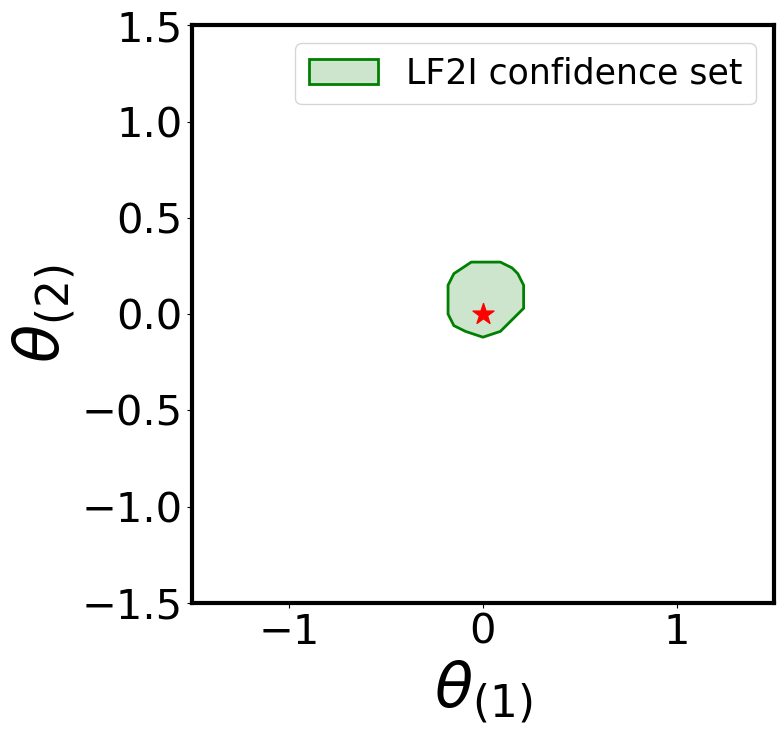

In [11]:
# The red star in the plot is the true parameter

plot_parameter_region(
    parameter_region=confidence_region[0],
    param_dim=PARAM_DIM,
    true_parameter=true_param_consistent,
    param_names=['theta0', 'theta1'],
    parameter_space_bounds={'theta0': simulator.poi_space_bounds, 'theta1': simulator.poi_space_bounds},
    alpha_shape=True,  # contour,
    alpha=2,  # hyperparameter for contour (the lower, the more it converges to a convex hull)
    scatter=False,  # don't plot evaluation points
    figsize=(7.5, 7.5),
    region_name='LF2I confidence set'
)

Posterior Credible Region

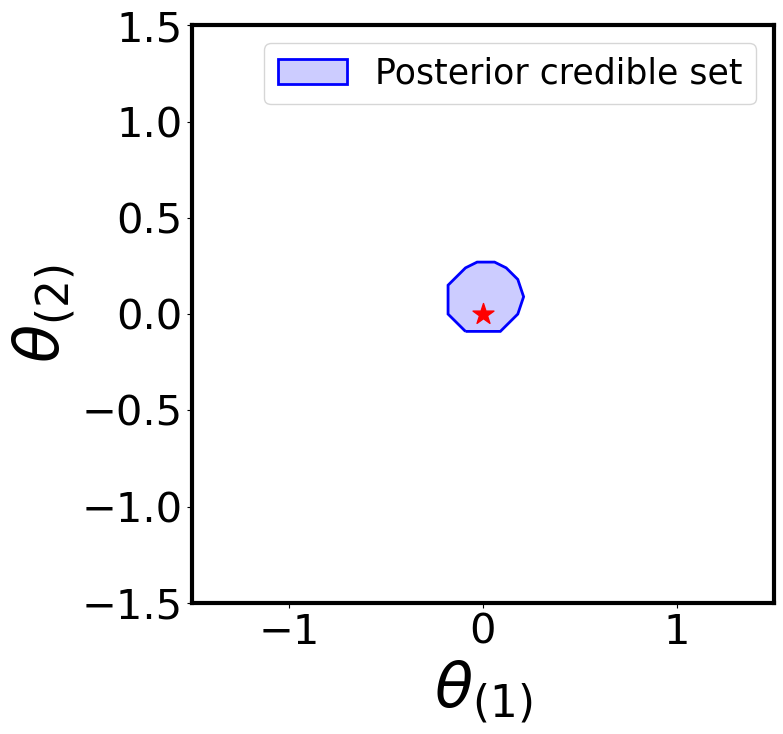

In [12]:
plot_parameter_region(
    parameter_region=hpd_region(
        posterior=lf2i.test_statistic.estimator,
        param_grid=simulator.poi_grid,
        x=observed_x_consistent,
        confidence_level=CONFIDENCE_LEVEL
    )[1],
    param_dim=PARAM_DIM,
    true_parameter=true_param_consistent,
    param_names=['theta0', 'theta1'],
    parameter_space_bounds={'theta0': simulator.poi_space_bounds, 'theta1': simulator.poi_space_bounds},
    alpha_shape=True,  # contour,
    alpha=2,  # hyperparameter for contour (the lower, the more it converges to a convex hull)
    scatter=False,  # don't plot evaluation points
    figsize=(7.5, 7.5),
    color='blue',
    region_name='Posterior credible set'
)

### Observation *not* consistent with the prior

Waldo Confidence Region

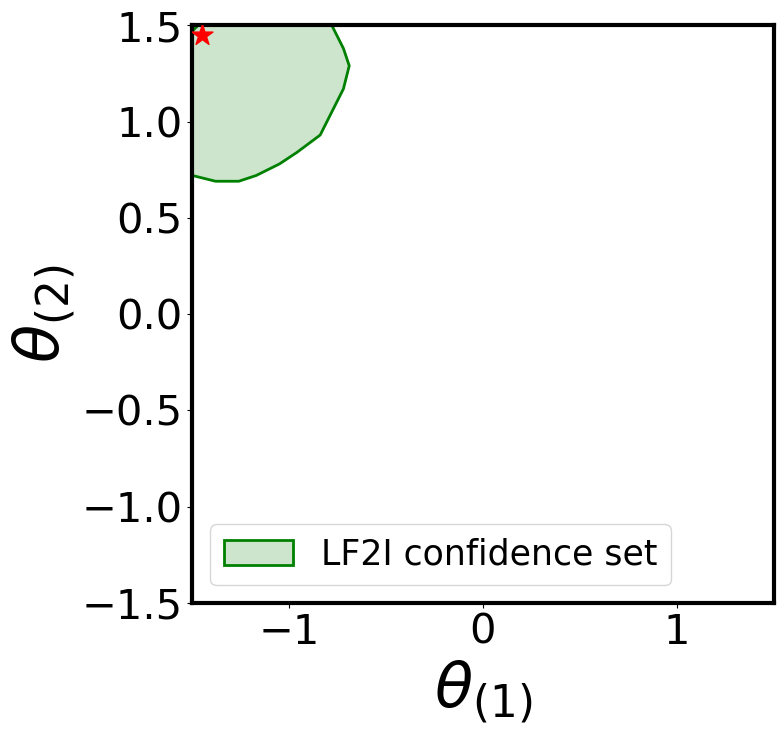

In [13]:
plot_parameter_region(
    parameter_region=confidence_region[1],
    param_dim=PARAM_DIM,
    true_parameter=true_param_notconsistent,
    param_names=['theta0', 'theta1'],
    parameter_space_bounds={'theta0': simulator.poi_space_bounds, 'theta1': simulator.poi_space_bounds},
    alpha_shape=True,  # contour,
    alpha=2,  # hyperparameter for contour (the lower, the more it converges to a convex hull)
    scatter=False,  # don't plot evaluation points
    figsize=(7.5, 7.5),
    region_name="LF2I confidence set"
)

Posterior Credible Region

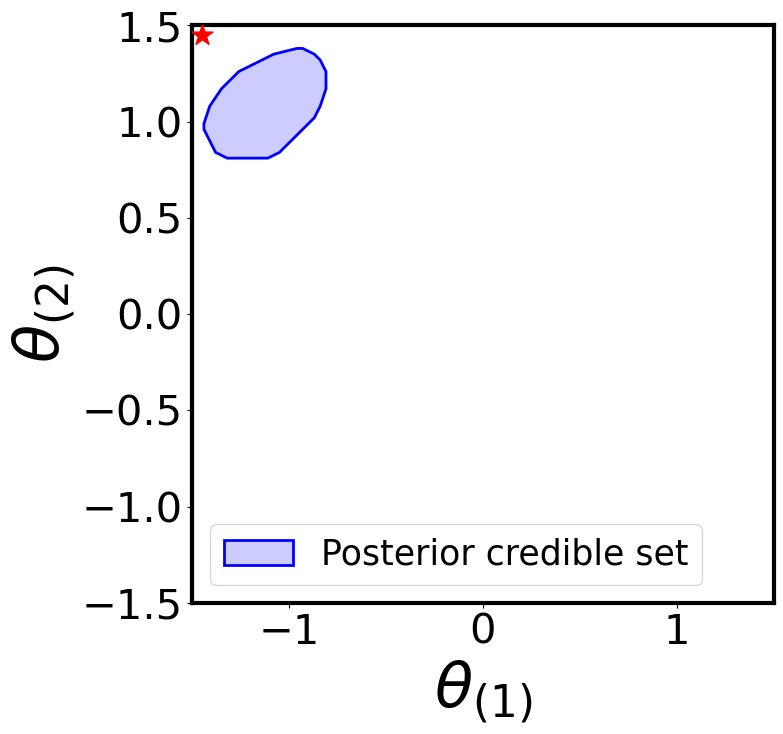

In [14]:
plot_parameter_region(
    parameter_region=hpd_region(
        posterior=lf2i.test_statistic.estimator,
        param_grid=simulator.poi_grid,
        x=observed_x_notconsistent,
        confidence_level=CONFIDENCE_LEVEL
    )[1],
    param_dim=PARAM_DIM,
    true_parameter=true_param_notconsistent,
    param_names=['theta0', 'theta1'],
    parameter_space_bounds={'theta0': simulator.poi_space_bounds, 'theta1': simulator.poi_space_bounds},
    alpha_shape=True,  # contour,
    alpha=2,  # hyperparameter for contour (the lower, the more it converges to a convex hull)
    scatter=False,  # don't plot evaluation points
    figsize=(7.5, 7.5),
    color='blue',
    region_name="Posterior credible set"
)

## DIAGNOSTICS

In [15]:
from lf2i.plot.coverage_diagnostics import coverage_probability_plot

#### Posterior Credible Regions

Note that for this example we are using the simulator to obtain training datasets. If one has pre-simulated datasets, they can be given as inputs directly to the `inference` method.

In [24]:
# this will take a few minutes because it has to compute a HPD credible region for each pair of (theta, x) in the simulated set
# the code is parallelied, but one can make it faster by decreasing the argument num_p_levels, which controls the number of level sets examined to construct the HPD region
# note that this might cause the credibility level of the HPD region to be only approximately equal to CONFIDENCE LEVEL
diagnostic_estimator, parameters, mean_proba, upper_proba, lower_proba = lf2i.diagnostics(
    region_type='posterior',
    simulator=simulator,
    b_double_prime=10_000,
    evaluation_grid=simulator.poi_grid.reshape(-1, PARAM_DIM),
    confidence_level=CONFIDENCE_LEVEL,
    posterior_estimator=lf2i.test_statistic.estimator
)

Computing indicators for 10000 credible regions: 100%|██████████| 10000/10000 [11:54<00:00, 14.00it/s]


Coverage of posterior credible regions can be very erratic: they tend to overcover close to the “bulk” of the prior and severely undercover far from it. The correct level here is 90%

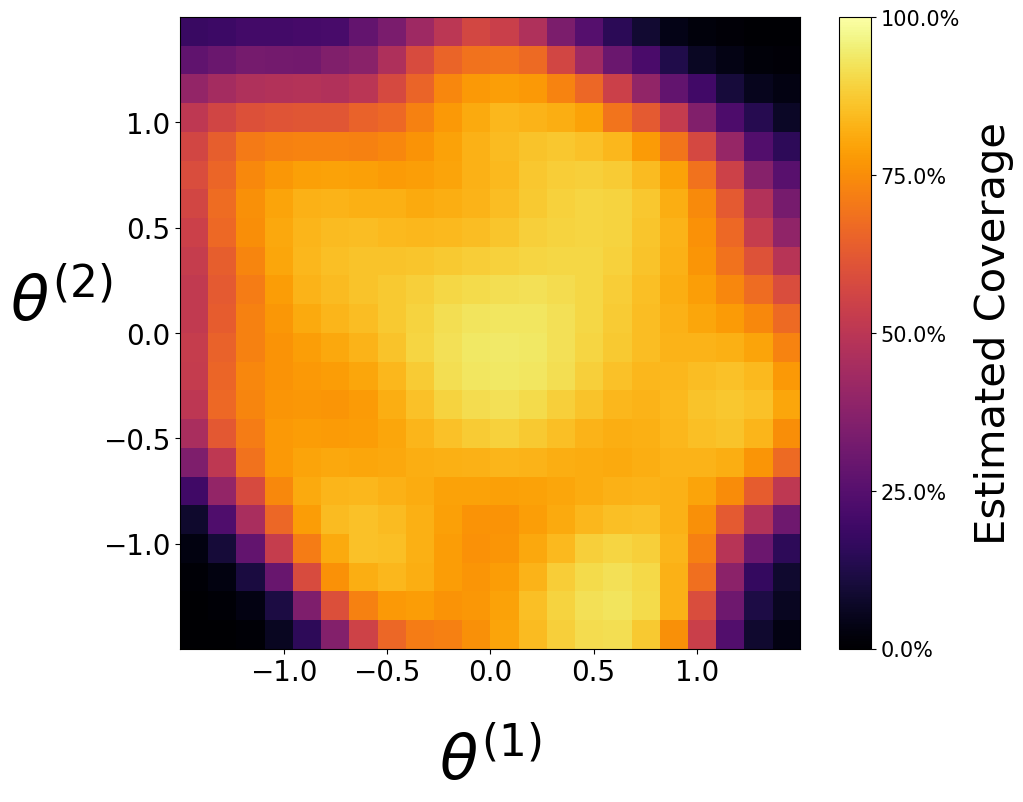

In [26]:
coverage_probability_plot(
    parameters=parameters,
    coverage_probability=mean_proba, 
    upper_proba=None,
    lower_proba=None,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(10, 8.2)
)

#### Waldo Confidence Regions

Note that for this example we are using the simulator to obtain training datasets. If one has pre-simulated datasets, they can be given as inputs directly to the `inference` method.

In [30]:
diagnostic_estimator, parameters, mean_proba, upper_proba, lower_proba = lf2i.diagnostics(
    region_type='lf2i',
    simulator=simulator,
    b_double_prime=10_000,
)

Approximating conditional mean and covariance for 20000 points...: 100%|██████████| 20000/20000 [13:21<00:00, 24.94it/s]


Coverage of Waldo is approximately 90% everywhere, as desired

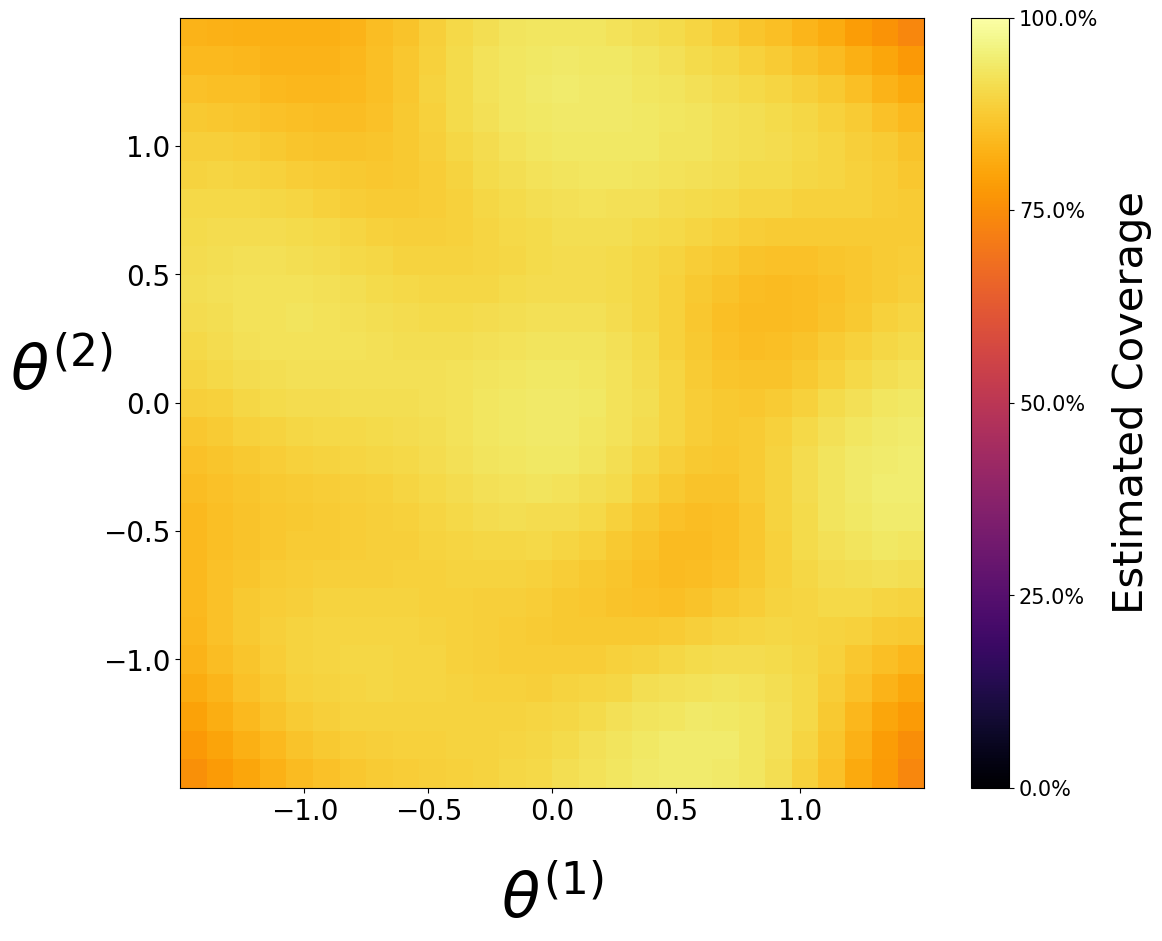

In [31]:
coverage_probability_plot(
    parameters=parameters,
    coverage_probability=mean_proba, 
    upper_proba=upper_proba,
    lower_proba=None,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(12, 10)
)